In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install bitsandbytes-cuda110

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 14.9 MB/s 


In [ ]:
import time
import copy

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from torch.utils.data.dataset import random_split
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler

import numpy as np

import matplotlib.pyplot as plt

from torchinfo import summary

import bitsandbytes as bnb

In [ ]:
# Hyper-parameters
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2
num_classes = 10
batch_size = 128
num_epochs = 2
learning_rate = 0.01

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('data', train=False, transform=transform)

# Before
print('Train data set:', len(train_dataset))
print('Test data set:', len(test_dataset))

# Random split
train_set_size = int(len(train_dataset) * 0.8)
indices = list(range(train_set_size))
split = int(np.floor(.2 * train_set_size))
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler =  SequentialSampler(val_indices)
   

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           sampler=train_sampler,
                                           batch_size=batch_size,
                                           )

valid_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           sampler=valid_sampler,
                                           batch_size=batch_size,
                                           )

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Train data set: 60000
Test data set: 10000


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
def train_val_model(model, criterion, optimizer, dataloaders, num_epochs=25,
        scheduler=None, log_interval=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Store losses and accuracies accross epochs
    losses, accuracies = dict(train=[], val=[]), dict(train=[], val=[])

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        if log_interval is not None and epoch % log_interval == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            nsamples = 0
            for inputs, labels in dataloaders[phase]:
                
                inputs = inputs.reshape(-1, sequence_length, input_size).to(device)
                labels = labels.to(device)
                nsamples += inputs.shape[0]

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    with torch.cuda.amp.autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # scale gradint and perform backward pass
                        #loss.backward()
                        scaler.scale(loss).backward()
                        
                        # before gradient clipping the optimizer parameters must be unscaled.
                        scaler.unscale_(optimizer)
                        
                        # perform optimization step
                        #optimizer.step()
                        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.5)
                        scaler.step(optimizer)
                        scaler.update()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if scheduler is not None and phase == 'train':
                scheduler.step()

            #nsamples = dataloaders[phase].dataset.data.shape[0]
            epoch_loss = running_loss / nsamples
            epoch_acc = running_corrects.double() / nsamples

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            if log_interval is not None and epoch % log_interval == 0:
                print('{} Loss: {:.4f} Acc: {:.5f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        if log_interval is not None and epoch % log_interval == 0:
            print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.5f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, losses, accuracies

In [ ]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
summary(model, input_size=(batch_size, sequence_length, input_size))

Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [128, 10]                 --
├─LSTM: 1-1                              [128, 28, 128]            212,992
├─Linear: 1-2                            [128, 10]                 1,290
Total params: 214,282
Trainable params: 214,282
Non-trainable params: 0
Total mult-adds (M): 763.53
Input size (MB): 0.40
Forward/backward pass size (MB): 3.68
Params size (MB): 0.86
Estimated Total Size (MB): 4.94

RNN(
  (lstm): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)
Total number of parameters = 214282
Epoch 0/19
----------
train Loss: 0.4033 Acc: 0.86607
val Loss: 0.1396 Acc: 0.95948

Epoch 1/19
----------
train Loss: 0.1273 Acc: 0.96242
val Loss: 0.1026 Acc: 0.96979

Epoch 2/19
----------
train Loss: 0.1018 Acc: 0.97010
val Loss: 0.1002 Acc: 0.97167

Epoch 3/19
----------
train Loss: 0.0834 Acc: 0.97568
val Loss: 0.0991 Acc: 0.97156

Epoch 4/19
----------
train Loss: 0.0843 Acc: 0.97549
val Loss: 0.1012 Acc: 0.97146

Epoch 5/19
----------
train Loss: 0.0803 Acc: 0.97607
val Loss: 0.1022 Acc: 0.97042

Epoch 6/19
----------
train Loss: 0.1066 Acc: 0.96823
val Loss: 0.1035 Acc: 0.96969

Epoch 7/19
----------
train Loss: 0.1044 Acc: 0.96896
val Loss: 0.0958 Acc: 0.97094

Epoch 8/19
----------
train Loss: 0.0880 Acc: 0.97458
val Loss: 0.1085 Acc: 0.96885

Epoch 9/19
----------
train Loss: 0.0958 Acc: 0.97221
val Loss: 0.1188 Acc: 

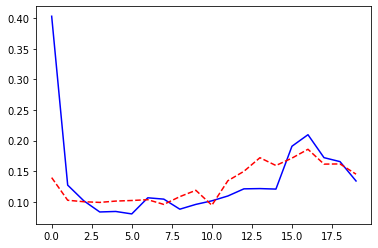

In [ ]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
dataloaders = dict(train=train_loader, val=valid_loader)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)
print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))
model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders, num_epochs=20, log_interval=1)
_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {:.5f} '.format(correct / total))

Accuracy of the network on the 10000 test images: 0.96970 
